In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# Specify data directory
data_dir = '/content/drive/My Drive/Vegetable Images'

# Define transforms for the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Load datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

# Define dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'validation', 'test']}

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define VGG19 model
model = models.vgg19(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
num_classes = len(image_datasets['train'].classes)
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(512, num_classes))

# Move model to GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = corrects.double() / len(image_datasets[phase])

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training finished!")


train Loss: 0.7836 Acc: 0.8256
validation Loss: 0.1334 Acc: 0.9757
train Loss: 0.2639 Acc: 0.9261
validation Loss: 0.0825 Acc: 0.9823
train Loss: 0.2229 Acc: 0.9343
validation Loss: 0.0593 Acc: 0.9853
train Loss: 0.1947 Acc: 0.9397
validation Loss: 0.0494 Acc: 0.9867
train Loss: 0.1745 Acc: 0.9490
validation Loss: 0.0458 Acc: 0.9880
train Loss: 0.1663 Acc: 0.9485
validation Loss: 0.0417 Acc: 0.9883
train Loss: 0.1658 Acc: 0.9481
validation Loss: 0.0414 Acc: 0.9897
train Loss: 0.1556 Acc: 0.9507
validation Loss: 0.0364 Acc: 0.9900
train Loss: 0.1550 Acc: 0.9509
validation Loss: 0.0340 Acc: 0.9900
train Loss: 0.1460 Acc: 0.9528
validation Loss: 0.0308 Acc: 0.9910
Training finished!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


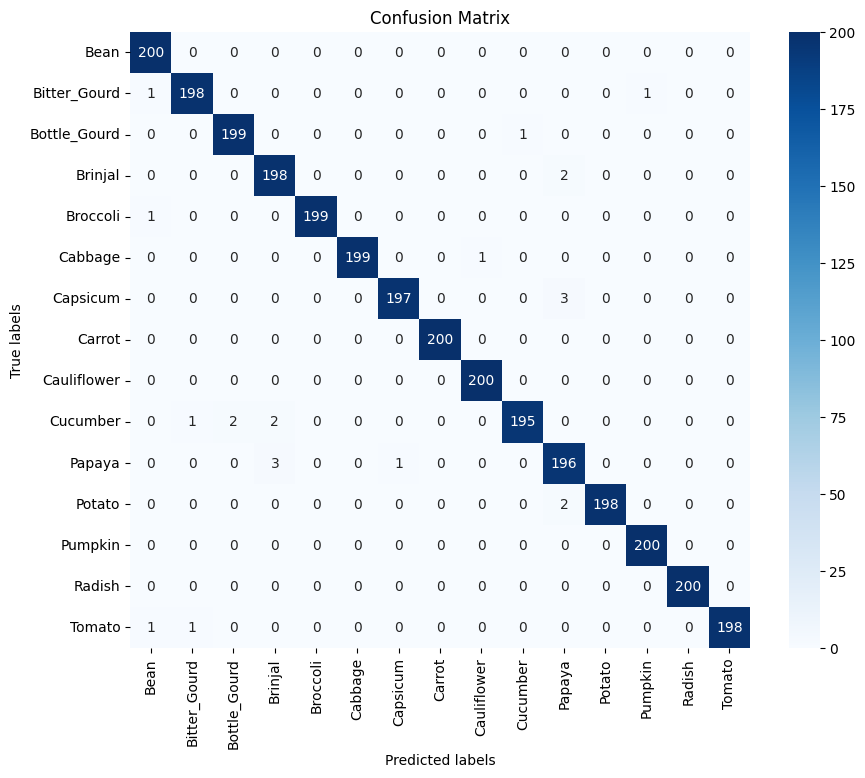

In [12]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Test the model
y_true, y_pred = test_model(model, dataloaders['test'])

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=image_datasets['test'].classes, yticklabels=image_datasets['test'].classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
